In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


* `KT023472.1` : Oena capensis beta-fibrinogen
* `KT023376.1` : Oena capensis cytb
* `EF373383.1` : Oena capensis COI

In [2]:
from Bio import Entrez
Entrez.email = "ryneches@ucdavis.edu"

terms = { 'COI'  : [ 'COI[gene] 350:450[slen]', 'cytochrome oxidase subunit I 350:450[slen]' ],
          'CYTB' : [ 'cytb[gene] 800:1200[slen]', 'cytochrome b 800:1200[slen]' ],
          'ND2'  : [ 'ND2[gene] 980:1100[slen]', 'NADH dehydrogenase subunit 2 980:1100[slen]' ],
          'IRBP' : [ 'IRBP[gene] 600:1000[slen]' ],
          'RAG1' : [ 'RAG1[gene] 2000:3000[slen]', 'RAG-1[gene] 2000:3000[slen]' ],
          'FGB'  : [ 'FGB[gene] 800:1300[slen]', 'beta fibrinogen 800:1300[slen]', 
                     'fibrinogen beta 800:1300[slen]', 'beta-fibrinogen 450:1300[slen]' ],
          'MB'   : [ 'MB[gene] 700:900[slen]', 'myoglobin 700:900[slen]' ],
          'NGF'  : [ 'NGF[gene] 600:1000[slen]', 'nerve growth factor beta polypeptide 600:1000[slen]' ],
          'NTF3' : [ 'NTF3[gene] 600:1000[slen]', 'neurotrophin 3 600:1000[slen]' ],
          '12S'  : [ '12S ribosomal 300:500[slen]' ]
        }

def find_txid( species ) :
    handle = Entrez.esearch(db='taxonomy', term=species)
    record = Entrez.read(handle)
    if int(record['Count']) == 0 :
        raise Exception( 'no records found' )
    txid = record['IdList'][0]
    return txid

def find_gene( txid, gene ) :
    taxid_query = 'txid' + str(txid) + '[Orgn] '
    query = ' or '.join( [ taxid_query + s for s in terms[gene] ] )
    #print query
    handle = Entrez.esearch(db='nucleotide', term=query )
    record = Entrez.read(handle)
    if int(record['Count']) == 0 :
        raise Exception( 'no genes found' )
    
    ntid = record['IdList'][0]
    fasta = Entrez.efetch( db='nucleotide', id=ntid, rettype='fasta', retmode='text' )
    return fasta.read()

In [3]:
birdnames = """Columba guinea
Columba speciosa
Metriopelia ceciliae
Leptotila jamaicensis
Leptotila plumbeiceps
Leptotila verreauxi
Leptotila rufaxilla
Phapitreron leucotis
Ptilinopus occipitalis
Streptopelia capicola
Streptopelia senegalensis
Streptopelia decaocto
Patagioenas fasciata
Columba subvinacea
Claravis pretiosa
Columba livia
Columba plumbea
Columbina inca
Columbina passerina
Geotrygon montana
Phapitreron amethystina
Zenaida asiatica
Zenaida galapagoensis
Zenaida macroura
Oena capensis"""

birdnames = sorted(birdnames.split('\n'))

In [4]:
birdids = []
for name in birdnames :
    bid = find_txid( name )
    birdids.append(bid)
    print name, bid
bird_nametoid = zip( birdnames, birdids )

Claravis pretiosa 115590
Columba guinea 135627
Columba livia 8932
Columba plumbea 372349
Columba speciosa 372313
Columba subvinacea 115599
Columbina inca 115616
Columbina passerina 111974
Geotrygon montana 115651
Leptotila jamaicensis 135629
Leptotila plumbeiceps 135630
Leptotila rufaxilla 115657
Leptotila verreauxi 135631
Metriopelia ceciliae 115677
Oena capensis 115679
Patagioenas fasciata 372321
Phapitreron amethystina 444154
Phapitreron leucotis 135632
Ptilinopus occipitalis 135633
Streptopelia capicola 135634
Streptopelia decaocto 177147
Streptopelia senegalensis 135635
Zenaida asiatica 93382
Zenaida galapagoensis 115708
Zenaida macroura 47245


In [5]:
bird_genes = {}
for species, txid in bird_nametoid :
    bird_genes[species] = {}
    for genename in terms.keys() :
        try :
            bird_genes[species][genename] = find_gene( txid, genename )
        except :
            #bird_genes[species][genename] = ''
            continue
    print species, ':', ' '.join( sorted(bird_genes[species].keys()) )

Claravis pretiosa : COI CYTB FGB IRBP ND2 RAG1
Columba guinea : COI CYTB FGB ND2
Columba livia : 12S COI CYTB FGB IRBP MB ND2 NGF NTF3 RAG1
Columba plumbea : COI CYTB FGB ND2
Columba speciosa : COI CYTB IRBP ND2 RAG1
Columba subvinacea : COI CYTB FGB ND2
Columbina inca : COI CYTB FGB ND2
Columbina passerina : COI CYTB FGB MB ND2 NGF NTF3
Geotrygon montana : COI CYTB FGB IRBP MB ND2 NGF NTF3 RAG1
Leptotila jamaicensis : COI CYTB FGB ND2
Leptotila plumbeiceps : COI CYTB ND2
Leptotila rufaxilla : COI CYTB FGB IRBP ND2 RAG1
Leptotila verreauxi : COI CYTB FGB ND2
Metriopelia ceciliae : COI CYTB FGB ND2
Oena capensis : 12S CYTB FGB IRBP ND2 RAG1
Patagioenas fasciata : COI CYTB FGB ND2
Phapitreron amethystina : COI CYTB FGB IRBP ND2 RAG1
Phapitreron leucotis : COI CYTB FGB ND2
Ptilinopus occipitalis : 12S COI CYTB ND2
Streptopelia capicola : COI CYTB IRBP ND2 RAG1
Streptopelia decaocto : COI CYTB FGB ND2
Streptopelia senegalensis : COI CYTB ND2
Zenaida asiatica : COI CYTB FGB ND2
Zenaida gala

In [6]:
import pandas
from Bio.SeqIO import parse
from Bio.SeqRecord import SeqRecord
from StringIO import StringIO

def str2seq( s ) :
    if type( s ) == float :
        return SeqRecord( '' )
    return parse( StringIO( s ), 'fasta' ).next()

bird_genetable = pandas.DataFrame( bird_genes ).T
#bird_genetable.applymap( lambda x : str2seq( x ).description ).T
bird_genetable.applymap( lambda x : len(str2seq( x )) )

,12S,COI,CYTB,FGB,IRBP,MB,ND2,NGF,NTF3,RAG1
Claravis pretiosa,0,383,1045,476,804,0,1041,0,0,2673
Columba guinea,0,383,972,895,0,0,1066,0,0,0
Columba livia,446,383,1045,840,804,717,1067,802,951,2865
Columba plumbea,0,383,1045,1139,0,0,1092,0,0,0
Columba speciosa,0,383,1045,0,804,0,1066,0,0,2733
Columba subvinacea,0,379,1045,1154,0,0,1066,0,0,0
Columbina inca,0,383,1039,1114,0,0,1091,0,0,0
Columbina passerina,0,383,1045,1137,0,730,1089,736,728,0
Geotrygon montana,0,383,1010,992,804,740,1066,711,711,2658
Leptotila jamaicensis,0,383,1017,578,0,0,1041,0,0,0


In [24]:
def rename_fasta( s ) :
    if type( s ) == float :
        return SeqRecord( '' )
    fasta = parse( StringIO( s ), 'fasta' ).next()
    description = fasta.description.replace('PREDICTED:', '')
    fasta.id = '_'.join( description.split()[1:3] )
    fasta.description = ''
    return fasta.format('fasta')

g = bird_genetable['NGF'].dropna()
g.apply( rename_fasta )

Columba livia          >Columba_livia\nAAGCAGGACCCGGCTCAGCTGGCGCAGAAC...
Columbina passerina    >Columbina_passerina\nCTGTACTACACTCTGACTGTAGCT...
Geotrygon montana      >Geotrygon_montana\nTTGATCGGCACACAGGCAGCTCCAAA...
Name: NGF, dtype: object

In [25]:
for gene in bird_genetable.columns :
    f = open( 'bird_' + gene + '.fasta', 'w' )
    g = bird_genetable[gene].dropna()
    g = g.apply( rename_fasta )
    for record in g :
        f.write( record )
    f.close()

In [26]:
!clustalo -v --threads 4 -i bird_12S.fasta        -o bird_12S_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_COI.fasta        -o bird_COI_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_CYTB.fasta       -o bird_CYTB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_FGB.fasta        -o bird_FGB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_IRBP.fasta       -o bird_IRBP_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_MB.fasta         -o bird_MB_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_ND2.fasta        -o bird_ND2_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_NGF.fasta        -o bird_NGF_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_NTF3.fasta       -o bird_NTF3_aln.fasta
!echo
!clustalo -v --threads 4 -i bird_RAG1.fasta       -o bird_RAG1_aln.fasta

Using 4 threads
Read 3 sequences (type: DNA) from bird_12S.fasta
not more sequences (3) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.01u 0.00s 00:00:00.01 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 0.21u 0.00s 00:00:00.21 Elapsed: 00:00:00
Alignment written to bird_12S_aln.fasta

Using 4 threads
Read 24 sequences (type: DNA) from bird_COI.fasta
not more sequences (24) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.08u 0.00s 00:00:00.08 Elapsed: 00:00:00
Guide-tree computation done.
Progressive alignment progress done. CPU time: 1.09u 0.04s 00:00:01.13 Elapsed: 00:00:00
Alignment written to bird_COI_aln.fasta

Using 4 threads
Read 25 sequences (type: DNA) from bird_CYTB.fasta
not more sequences (25) than cluster-size (100), turn off mBed
Calculating pairwise ktu

In [45]:
from Bio import AlignIO
from Bio.Nexus import Nexus
from Bio import Alphabet
from glob import glob

nexi = [ (alnfile, Nexus.Nexus( AlignIO.read( alnfile, 'fasta', alphabet=Alphabet.generic_dna  ).format('nexus') ) ) 
          for alnfile in glob( 'bird*_aln.fasta' ) ]
combined = Nexus.combine( nexi )
f = open('bird.nex', 'w')
combined.write_nexus_data(f)
f.close()

# RAxML needs a phylip file
combined.export_phylip('bird.phylip')

'bird.phylip'

In [46]:
# RAxML partition file
f = open( 'bird.txt', 'w' )
for key in combined.charsets.keys() :
    s = 'DNA, ' + key.split('_')[1] + ' = ' + str(combined.charsets[key][0]+1) + '-' + str(combined.charsets[key][-1]+1)
    f.write( s + '\n' )
    print s
f.close()

DNA, CYTB = 6397-7473
DNA, ND2 = 5304-6396
DNA, COI = 4105-4499
DNA, IRBP = 4500-5303
DNA, FGB = 1-1239
DNA, RAG1 = 1240-4104


In [51]:
!raxmlHPC -m MULTICAT -q bird.txt -s bird.phylip -n bird -p 10001

Use raxml with AVX support (2 cpus)

This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1


This is RAxML version 8.2.9 released by Alexandros Stamatakis on July 20 2016.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp   (KIT and HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
Charlie Taylor    (UF)


Alignment has 2272 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 44.46%

RAxML rapid hill-climbing mode

Using 6 distinct models/data partitions with joint branch length optimization


Executing 1 inferences on the original alignment using 1 distinct randomized MP trees

All free model parameters will be estimated by RAxML
ML estimate of 25 per site rate categories

Likelihood of final tree will be evaluated and optimized under

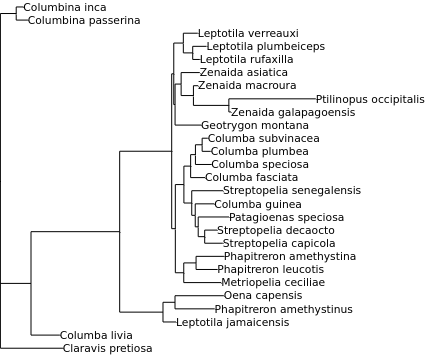

In [53]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( 'RAxML_bestTree.bird' )

#ete_tree.set_outgroup('Claravis_pretiosa')

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)